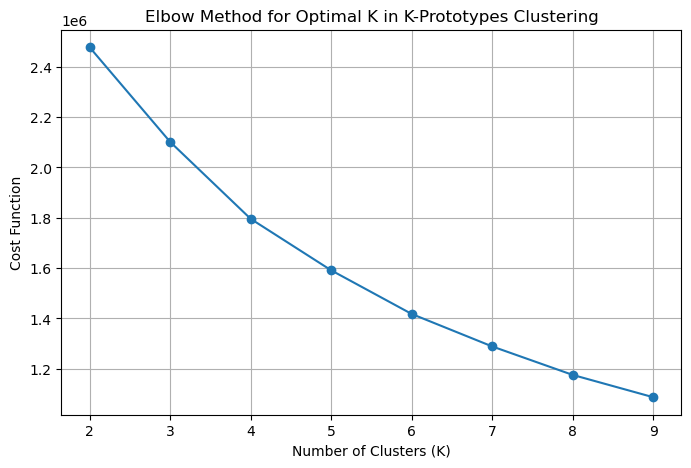

In [39]:
import warnings
warnings.filterwarnings('ignore')

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = "shopping_behavior_updated.csv"
df = pd.read_csv(file_path)

# Use all available features
df_full = df.copy()
df_full.drop(['Customer ID'], axis=1, inplace=True)

# Identify categorical and numerical columns
categorical_cols = df_full.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_full.select_dtypes(include=['number']).columns.tolist()

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_full[col] = le.fit_transform(df_full[col])
    label_encoders[col] = le

# Convert dataframe to numpy array for KPrototypes
df_full_np = df_full.to_numpy()

# Determine the optimal number of clusters using the elbow method
costs = []
K_range = range(2, 10)
for k in K_range:
    kp = KPrototypes(n_clusters=k, init="Cao", n_init=5, verbose=0)
    clusters = kp.fit_predict(df_full_np, categorical=[df_full.columns.get_loc(col) 
                                                       for col in categorical_cols])
    costs.append(kp.cost_)

# Plot the cost function to find the optimal K
plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost Function")
plt.title("Elbow Method for Optimal K in K-Prototypes Clustering")
plt.grid(True)
plt.show()



In [45]:
# Apply K-Prototypes clustering with optimal K (assume 4 for now, replace based on the plot)
optimal_k = 6
kprototypes_model = KPrototypes(n_clusters=optimal_k, init="Cao", n_init=5, verbose=0)
df_full["prod_cluster"] = kprototypes_model.fit_predict(df_full_np, categorical=[df_full.columns.get_loc(col) for col in categorical_cols])

# Decode cluster composition back to human-readable values
def decode_cluster(row):
    for col in categorical_cols:
        row[col] = label_encoders[col].inverse_transform([int(row[col])])[0]
    return row

cluster_composition = df_full.groupby("prod_cluster").apply(lambda x: x.mode().iloc[0]).apply(decode_cluster, axis=1)

# Investigate clustering results
cluster_counts = df_full["prod_cluster"].value_counts()
cluster_summary = df_full.groupby("prod_cluster").mean()


In [80]:
cluster_composition.T

prod_cluster,0,1,2,3,4,5
0,,,,,,
Age,28.0,52.0,25.0,50.0,69.0,27.0
Gender,Male,Male,Male,Male,Male,Male
Item Purchased,Blouse,Jewelry,Shirt,Handbag,Dress,Socks
Category,Clothing,Clothing,Clothing,Clothing,Clothing,Clothing
Purchase Amount (USD),94.0,26.0,64.0,51.0,85.0,23.0
Location,West Virginia,Maryland,New Hampshire,Connecticut,Louisiana,Nebraska
Size,M,M,M,M,M,M
Color,Green,Silver,White,Olive,Violet,Yellow
Season,Fall,Spring,Winter,Spring,Fall,Summer


1. Gender is not useful. I think it's because most of customers are male in this shopping mall.
2. Cluster 0, 1, 3, 4 are interesting. The mode for `Gender` is male, but mode for `Item Purchased` are items for women.
3. Cluster 0 and 4 are top spender. But they are distinctively different in many interesting ways.
4. We need to watch for cluster 3. Their `Review Rating` is pretty low.

In [ ]:
sns.bar

In [64]:
import seaborn as sns

<Axes: xlabel='prod_cluster', ylabel='count'>

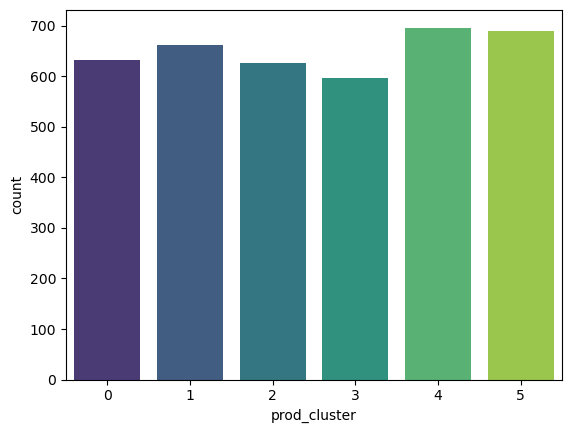

In [76]:
sns.barplot(cluster_counts, palette='viridis')

<Axes: xlabel='prod_cluster'>

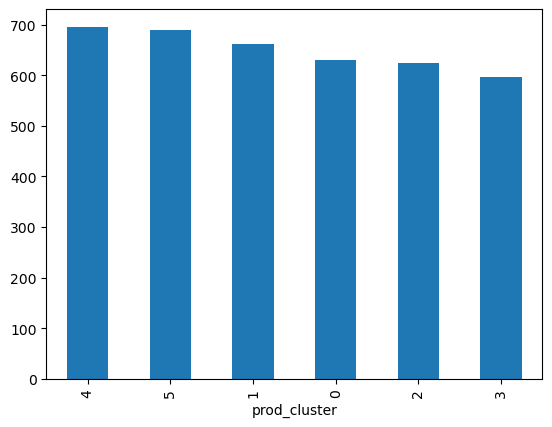

In [62]:
cluster_counts.plot(kind='bar')

They are evenly distributed.

In [78]:
cluster_counts

prod_cluster
4    696
5    689
1    662
0    631
2    625
3    597
Name: count, dtype: int64

In [58]:
df_full[df_full["prod_cluster"] == 0]

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,prod_cluster
1,19,1,23,1,64,18,0,12,3,3.1,1,1,1,1,2,1,3,0
8,26,1,4,3,97,47,0,19,2,2.6,1,1,1,1,8,5,0,0
11,30,1,18,1,68,10,2,13,3,4.9,1,5,1,1,10,0,3,0
42,20,1,4,3,100,41,1,0,1,4.1,1,2,1,1,15,4,0,0
43,25,1,15,0,69,34,0,10,0,3.7,1,5,1,1,19,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879,26,0,19,1,63,8,0,12,3,4.1,0,2,0,0,6,3,5,0
3882,35,0,13,1,95,33,0,2,0,2.6,0,2,0,0,24,1,3,0
3888,45,0,20,2,69,45,1,22,1,3.4,0,4,0,0,14,5,1,0
3892,35,0,12,0,86,21,0,9,2,3.5,0,4,0,0,5,4,3,0
